<font color='green'> 
 Используя для обработки текстов токенизатор nltk.tokenize и векторизатор TfidfVectorizer    
<br>
 подберем лучшую модель классификатора и ее параметры
<br>
 методами GridSearchCV и RandomizedSearchCV

### 1. Импорт библиотек

In [12]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import uniform

In [14]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package punkt to /home/avm/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/avm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
import regex
from tqdm import tqdm
import pickle
import os
import inspect
import sys
from icecream import ic

In [16]:
base_dir = 'data_out'
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

def save_pickle(obj, fname, dir=base_dir):
    full_fname = dir + '/' + fname
    with open(full_fname, 'wb') as pickle_file:
        pickle.dump(obj, pickle_file)
    print(f"saved \"{fname}\" ({sizeof_fmt(os.path.getsize(full_fname))}).")

def load_pickle(fname, dir=base_dir):
    full_fname = dir + '/' + fname
    with open(full_fname, 'rb') as pickle_file:
        obj = pickle.load(pickle_file)
    print(f"loaded \"{fname}\" ({sizeof_fmt(os.path.getsize(full_fname))}).")
    return obj

### 2. Загрузка заранее предобработанных данных

In [17]:
train_df = pd.read_csv('data_out/train_df.csv')
val_df = pd.read_csv('data_out/val_df.csv')

train_df.head()

,TweetID,entity,sentiment,Tweet content,clean_text,label,lemms,emb_w2v
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,coming borders kill,2,come border kill,[-0.09283447 0.4025879 0.22436523 0.125976...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,im getting borderlands kill,2,im get borderlands kill,[-1.37634277e-01 -9.19189453e-02 7.32421875e-...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,im coming borderlands murder,2,im come borderlands murder,[-0.21130371 -0.01263428 0.6118164 0.513671...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,im getting borderlands 2 murder,2,im get borderlands 2 murder,[-9.30175781e-02 -2.68737793e-01 3.24707031e-...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...,im getting borderlands murder,2,im get borderlands murder,[-0.19995117 -0.16326904 0.27148438 0.501953...


<font color='green'> 
 Удалим значения NaN, образовавшиеся из пустых строк после токенизации   
<br>
<br>

In [18]:
#train_df = train_df.dropna()
#train_df.isnull().sum()

In [19]:
#val_df = val_df.dropna()
#val_df.isnull().sum()

### 3.	Преобразование текста в векторное пространство.

<font color='green'> 
        Кодируем целевую метку. 
<br>

In [20]:
lab_enc = LabelEncoder()
train_df['label'] = lab_enc.fit_transform(train_df['sentiment'])

<font color='green'> 
     Разделим тренировочную выборку на обучающий и тестовый наборы. 
<br>

In [21]:
X_train, X_val, y_train, y_val = train_test_split(train_df['clean_text'], train_df['label'], test_size=0.2, random_state=42)


<font color='green'> 
        Векторизуем текст. 
<br>

In [22]:
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)

<font color='green'> 
        Готовим и векторизуем данные по валидационной выборке. 
<br>

In [23]:
X_valid_data = vectorizer.transform(val_df['clean_text'])

y_valid_data = val_df.sentiment


### 4	Применение модели логистической регрессии и оценка результатов.

<font color='green'> 
        Построим и обучим модель логистической регрессии. 
<br>

In [24]:
lr = LogisticRegression()
lr.fit(X_train_vec, y_train)

/home/avm/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

<font color='green'> 
        Оценим предсказания модели логистической регрессии. 
<br>

In [25]:
y_pred = lr.predict(X_val_vec)

accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

print('Accuracy:', accuracy)
print('Classification Report:')
print(report)

Accuracy: 0.8306980056980057
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      4218
           1       0.82      0.87      0.85      5958
           2       0.83      0.77      0.80      3864

    accuracy                           0.83     14040
   macro avg       0.83      0.82      0.83     14040
weighted avg       0.83      0.83      0.83     14040



<font color='green'> 
        Оценим предсказания логистической регрессии на валидационной выборке. 
<br>

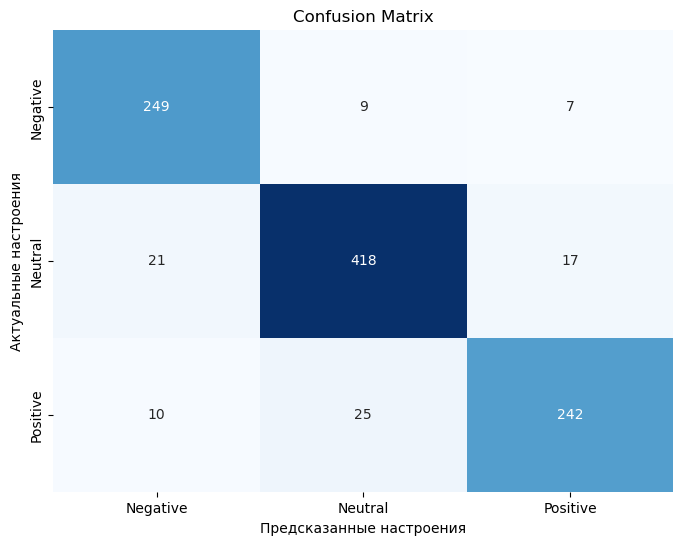

              precision    recall  f1-score   support

    Negative       0.89      0.94      0.91       265
     Neutral       0.92      0.92      0.92       456
    Positive       0.91      0.87      0.89       277

    accuracy                           0.91       998
   macro avg       0.91      0.91      0.91       998
weighted avg       0.91      0.91      0.91       998

Accuracy: 0.9108216432865731


In [26]:
y_valid_data_pred = lab_enc.inverse_transform(lr.predict(X_valid_data))

pred_df = pd.DataFrame({'Predicted Sentiment': y_valid_data_pred})
pred_df.to_csv('data_out/predicted_sentiments_LR.csv', index=False)

accuracy = accuracy_score(y_valid_data, y_valid_data_pred)

confusion = confusion_matrix(y_valid_data, y_valid_data_pred)

classification = classification_report(y_valid_data, y_valid_data_pred)

le = LabelEncoder()
le.fit(val_df['sentiment'])

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Предсказанные настроения')
plt.ylabel('Актуальные настроения')
plt.title('Confusion Matrix')
plt.show()


print(classification)
print('Accuracy:', accuracy)


<font color='green'> 
        Повторили предыдущий результат. 
<br>
    Теперь попробуем его улучшить, подобрав параметры через GridSearchCV

### 5	Применение метода GridSearchCV к логистической регрессии.

In [27]:
%%time
g_lr = LogisticRegression()

param_grid = {'C':[0.1,0.2,0.3,0.5,0.7,1],
              'penalty': ['l1', 'l2'],
              'solver': ['liblinear', 'saga']
}
grid = GridSearchCV(g_lr, param_grid, cv=10, scoring='accuracy')

grid.fit(X_train_vec, y_train)

/home/avm/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/avm/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/avm/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/avm/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/avm/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/avm/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: Con

CPU times: user 40min 14s, sys: 20.1 s, total: 40min 34s
Wall time: 34min 32s


GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 0.2, 0.3, 0.5, 0.7, 1],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy')

In [28]:
test_scores = grid.cv_results_['mean_test_score']
print(test_scores)

[0.60092919 0.60518509 0.66868456 0.69432644 0.63497602 0.64063862
 0.70629271 0.73163184 0.65657571 0.66006595 0.72839103 0.75410418
 0.68659811 0.69092524 0.756419   0.78282675 0.71202637 0.71900678
 0.77500948 0.80106096 0.7480676  0.75312468 0.79322596 0.81922399]


In [29]:
# examine the best model

# Single best score achieved across all params (k)
print(grid.best_score_)

# Dictionary containing the parameters (k) used to generate that score
print(grid.best_params_)

# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print(grid.best_estimator_)

0.8192239892128583
{'C': 1, 'penalty': 'l2', 'solver': 'saga'}
LogisticRegression(C=1, solver='saga')


<font color='green'> 
        Посчитаем модель логистической регрессии с оптимальными параметрами и оценим метрики. 
<br>

In [30]:
lr = LogisticRegression(C = 1, penalty = 'l2', solver = 'saga')
lr.fit(X_train_vec, y_train)

LogisticRegression(C=1, solver='saga')

<font color='green'> 
        Оценим предсказания модели логистической регрессии. 
<br>

In [31]:
y_pred = lr.predict(X_val_vec)

accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

print('Accuracy:', accuracy)
print('Classification Report:')
print(report)

Accuracy: 0.8318376068376069
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      4218
           1       0.82      0.87      0.85      5958
           2       0.83      0.77      0.80      3864

    accuracy                           0.83     14040
   macro avg       0.83      0.82      0.83     14040
weighted avg       0.83      0.83      0.83     14040



<font color='green'> 
        Оценим предсказания логистической регрессии на валидационной выборке. 
<br>

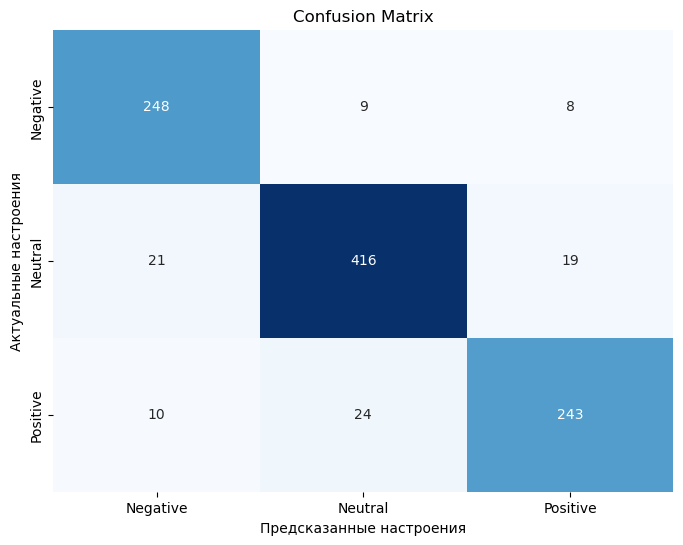

              precision    recall  f1-score   support

    Negative       0.89      0.94      0.91       265
     Neutral       0.93      0.91      0.92       456
    Positive       0.90      0.88      0.89       277

    accuracy                           0.91       998
   macro avg       0.91      0.91      0.91       998
weighted avg       0.91      0.91      0.91       998

Accuracy: 0.908817635270541


In [32]:
y_valid_data_pred = lab_enc.inverse_transform(lr.predict(X_valid_data))

pred_df = pd.DataFrame({'Predicted Sentiment': y_valid_data_pred})
pred_df.to_csv('data_out/predicted_sentiments_LR_grid.csv', index=False)

accuracy = accuracy_score(y_valid_data, y_valid_data_pred)

confusion = confusion_matrix(y_valid_data, y_valid_data_pred)

classification = classification_report(y_valid_data, y_valid_data_pred)

le = LabelEncoder()
le.fit(val_df['sentiment'])

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Предсказанные настроения')
plt.ylabel('Актуальные настроения')
plt.title('Confusion Matrix')
plt.show()


print(classification)
print('Accuracy:', accuracy)


<font color='green'> 
        Улучшить удалось лишь немного. 
<br>
    Теперь попробуем улучшить модель, подобрав оптимальный метод классификации и его параметры через RandomizedSearchCV

### 6	Применение метода RandomizedSearchCV.

In [33]:
models=[
      {'name':'NB',"model":BernoulliNB(), 'params':{'alpha': uniform(loc=0, scale=4)}},  
      {'name':'R',"model": Ridge(), 'params':{'alpha': uniform(loc=0, scale=4), 'solver':['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}},
      {'name':'SVC',"model": SVC(), 'params':{'kernel':['linear', 'poly', 'rbf', 'sigmoid'], 'gamma':['scale', 'auto']}},
      {'name':'RF',"model": RandomForestClassifier(), 'params':{'n_estimators':[10,25,50,100,150,200], 'criterion':['gini', 'entropy'], 'max_depth':[3,5,7,9,11]}},
      {'name':'KN',"model": KNeighborsClassifier(), 'params':{'n_neighbors':list(range(1,30)),'weights': ['uniform', 'distance'], 'p':[1,2,3]}},
      {'name':'DT',"model": DecisionTreeClassifier(), 'params':{'criterion':['gini', 'entropy'], 'max_depth':[3,5,7,9,11]}}

]

res=[]
for v in  models:
    res.append((v['name'], RandomizedSearchCV(v['model'], v['params'], cv=10).fit(X_train_vec, y_train)))

/home/avm/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:729: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(
/home/avm/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:729: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(
/home/avm/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:729: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(
/home/avm/anaconda3/li

/home/avm/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:729: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(
/home/avm/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:729: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(
/home/avm/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:729: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(
/home/avm/anaconda3/li

/home/avm/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/home/avm/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Se

/home/avm/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/home/avm/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Se

/home/avm/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/home/avm/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Se

In [34]:
for r in res: 
    print(r[0], r[1].best_score_, r[1].best_params_)

NB 0.8054772745723324 {'alpha': 0.21485488646690554}
R 0.5613369622155375 {'alpha': 2.242044673691745, 'solver': 'sag'}
SVC 0.9471134628703641 {'kernel': 'poly', 'gamma': 'scale'}
RF 0.4563553661717063 {'n_estimators': 10, 'max_depth': 11, 'criterion': 'entropy'}
KN 0.9149364745936429 {'weights': 'distance', 'p': 1, 'n_neighbors': 6}
DT 0.5114676360379834 {'max_depth': 11, 'criterion': 'gini'}


<font color='green'> 
        Наилучшего результата достигла модель на основе SVC при параметрах. {'kernel': 'poly', 'gamma': 'scale'} 
<br>
    Выполним ее отдельно.
<br>   
    Построим и обучим модель SVM (метод опорных векторов). 

In [35]:
svm = SVC(kernel='poly', gamma='scale')
svm.fit(X_train_vec, y_train)

SVC(kernel='poly')

<font color='green'> 
        Оценим предсказания SVM модели. 
<br>

In [36]:
y_pred = svm.predict(X_val_vec)

accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

print('Accuracy:', accuracy)
print('Classification Report:')
print(report)

Accuracy: 0.9564102564102565
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      4218
           1       0.94      0.98      0.96      5958
           2       0.97      0.92      0.95      3864

    accuracy                           0.96     14040
   macro avg       0.96      0.95      0.96     14040
weighted avg       0.96      0.96      0.96     14040



<font color='green'> 
        Оценим предсказания SVM модели на валидационной выборке. 
<br>

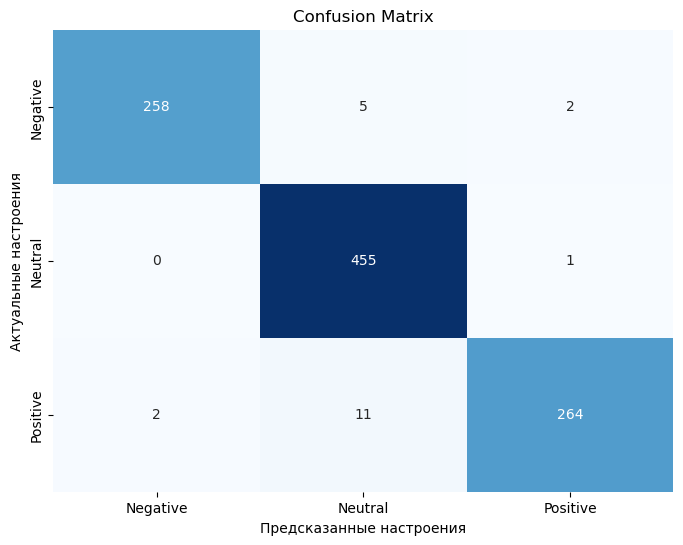

              precision    recall  f1-score   support

    Negative       0.99      0.97      0.98       265
     Neutral       0.97      1.00      0.98       456
    Positive       0.99      0.95      0.97       277

    accuracy                           0.98       998
   macro avg       0.98      0.97      0.98       998
weighted avg       0.98      0.98      0.98       998

Accuracy: 0.9789579158316634


In [37]:
y_valid_data_pred = lab_enc.inverse_transform(svm.predict(X_valid_data))

pred_df = pd.DataFrame({'Predicted Sentiment': y_valid_data_pred})
pred_df.to_csv('data_out/predicted_sentiments_SVM_best.csv', index=False)

accuracy = accuracy_score(y_valid_data, y_valid_data_pred)

confusion = confusion_matrix(y_valid_data, y_valid_data_pred)

classification = classification_report(y_valid_data, y_valid_data_pred)

le = LabelEncoder()
le.fit(val_df['sentiment'])

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Предсказанные настроения')
plt.ylabel('Актуальные настроения')
plt.title('Confusion Matrix')
plt.show()


print(classification)
print('Accuracy:', accuracy)


<font color='green'> 
        Показатель 0.97895 - это очень хороший результат.
<br>
    Конечно времени на обсчет ушло очень много, но кода для этого написал совсем мало.
<br>
    Можно сделать вывод, что применение метода RandomizedSearchCV очень эффективный метод повышения качества классификации.
<br>
    Классическую задачу классификации я решил.
<br>
    Теперь попробую с помощью примененных ранее с неудачным результатoм дополнительными методами обработки текстов сэммулировать работу NER и вытянуть из данных, что конкретно нравится или вызывает негатив у пользователей по конкретным темам-сущностям(entity).

In [38]:
save_pickle(svm, "svm.pickle")
save_pickle(lr, "lr.pickle")

saved "svm.pickle" (7.7 MiB).
saved "lr.pickle" (695.5 KiB).
